# DS Challenge ITA 2022

### Young Strategists

### Desafio
<p>O segundo desafio será constituído por (1) uma solução para construção de
carteira e (2) a apresentação de 15 minutos</p>

### Índice

* 1. Imports
* 2. Carga da base
* 3. Modelagem
> 3.1 Normalização do dataset<br>
> 3.2 Cálculo de taxa de retorno simples<br>
> 3.3 Cálculo de parametro Beta e Alpha<br>
> 3.4 Cálculo de CAPM (Capital Asset Pricing Model)<br>
> 3.5 Seleção de ativos para carteira<br>
> 3.6 Carteiras<br>
> 3.7 Alocação e Otimização das Carteiras<br>
> 3.8 Otimização das Carteira com Markowitz<br>
* 4. Resultados

# 1. Imports

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import mlrose

# Warnings remove 
import warnings
warnings.filterwarnings("ignore")


# 2. Carga da base

In [199]:
df = pd.read_csv('bases/basev2.csv')
df['Dia'] = pd.to_datetime(df['Dia'])
df= df.set_index('Dia')
df.index = pd.to_datetime(df.index)
df.rename(columns={'SPY':'SP500'}, inplace=True)
anos  = df.index.year.unique()
dataset = df.copy()
df

dfs = {}
for ano in anos:
    dfs[ano] = df[df.index.year == ano].copy()


# 3. Modelagem
## 3.1 Normalização do dataset

In [200]:
datasets_normalizados = {}

for ano in anos:
    dataset2 = []
    dataset2 = dataset[dataset.index.year ==ano].copy()
    dataset_normalizado = pd.DataFrame()
    for i in dataset2.columns:
        dataset_normalizado[i] = dataset2[i] / dataset2[i][0]
    datasets_normalizados[ano] = dataset_normalizado

datasets_normalizados[2015].head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SP500
Dia,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.981262,0.999444,0.986819,0.971828,0.981181,0.991488,0.993567,1.000223,0.983116,0.995024,...,0.988649,0.972638,0.993068,0.937763,0.979682,1.037304,0.985923,0.962531,0.993997,0.981940
2015-01-06,0.965976,0.983862,0.986125,0.971920,0.976324,0.996905,0.968373,0.988864,0.976024,0.974979,...,0.993909,0.967467,0.980743,0.932248,0.967657,1.028511,0.978820,0.925769,0.984299,0.972691
2015-01-07,0.978797,0.983305,1.007316,0.985548,1.015784,1.016803,0.999196,0.996882,0.996511,0.982997,...,1.002492,0.977270,1.006162,0.939601,0.999724,1.054090,1.003745,0.934606,1.004618,0.984812
2015-01-08,1.008136,0.995363,1.016145,1.023415,1.026408,1.019125,1.044224,1.017372,1.011706,1.008018,...,1.014120,0.993537,1.031003,0.946691,1.017139,1.065281,1.025184,0.947685,1.020088,1.002288


# 3.2 Cálculo de taxa de retorno simples

In [201]:
datasets_taxa_retorno = {}

for ano in anos:
    dataset_taxa_retorno = pd.DataFrame()
    dataset_normalizado = datasets_normalizados[ano].copy()
    
    dataset_taxa_retorno = (dataset_normalizado / dataset_normalizado.shift(1)) - 1
    
    # Não podemos ter valores 'NaN' em nossa base pois isso gera problemas nos calculos, substituimos por 0
    dataset_taxa_retorno.fillna(0, inplace=True)
    datasets_taxa_retorno[ano] = dataset_taxa_retorno
datasets_taxa_retorno[2015]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SP500
Dia,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.018738,-0.000556,-0.013181,-0.028172,-0.018819,-0.008512,-0.006433,0.000223,-0.016884,-0.004976,...,-0.011351,-0.027362,-0.006932,-0.062237,-0.020318,0.037304,-0.014077,-0.037469,-0.006003,-0.018060
2015-01-06,-0.015578,-0.015590,-0.000703,0.000094,-0.004950,0.005463,-0.025357,-0.011356,-0.007213,-0.020145,...,0.005321,-0.005316,-0.012410,-0.005881,-0.012274,-0.008477,-0.007205,-0.038193,-0.009756,-0.009419
2015-01-07,0.013272,-0.000566,0.021489,0.014022,0.040417,0.019960,0.031829,0.008108,0.020990,0.008223,...,0.008635,0.010133,0.025918,0.007887,0.033138,0.024870,0.025465,0.009546,0.020643,0.012461
2015-01-08,0.029975,0.012262,0.008765,0.038422,0.010459,0.002283,0.045064,0.020554,0.015249,0.025453,...,0.011599,0.016645,0.024689,0.007546,0.017420,0.010617,0.021359,0.013994,0.015399,0.017745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.008858,0.012012,0.000470,-0.005340,-0.002049,0.000096,0.023569,0.000000,-0.001820,-0.004224,...,-0.003068,-0.010725,-0.002130,-0.001616,-0.001619,0.001362,-0.002112,0.003975,0.003126,-0.001650
2015-12-28,-0.008543,-0.013239,0.009522,-0.011201,0.004961,0.002309,-0.015056,-0.001552,-0.001439,-0.001061,...,0.011192,-0.007437,0.004925,-0.003507,-0.002162,-0.006413,-0.011006,-0.005040,-0.004779,-0.002285
2015-12-29,0.013882,0.006246,0.010960,0.017974,0.011915,0.005567,0.043385,0.017544,0.011914,0.011996,...,0.002214,0.005334,0.011436,0.004331,0.005417,0.005086,0.002568,0.006151,0.008977,0.010672


In [202]:
# Anualização da Taxa média de retorno simples (Tx Média diaria * dias uteis do ano)
datasets_taxa_retorno[2015].mean() * 252

A        0.055566
AAL     -0.171689
AAP     -0.003683
AAPL    -0.002371
ABBV    -0.055248
           ...   
ZBH     -0.072254
ZBRA    -0.011748
ZION     0.002562
ZTS      0.144606
SP500    0.004481
Length: 503, dtype: float64

In [203]:
# Implementação para a base toda separado por anos
dataset_taxa_retorno_anos = pd.DataFrame()
for ano in anos:
    dataset_taxa_retorno = datasets_taxa_retorno[ano].copy()
    
    dias_do_ano = len(dataset_taxa_retorno)
    dataset_taxa_retorno_anos[ano] = dataset_taxa_retorno.mean() * dias_do_ano
dataset_taxa_retorno_anos.head()

,2015,2016,2017,2018,2019,2020,2021,2022
A,0.055566,0.140254,0.378714,0.034574,0.291364,0.388061,0.318371,0.057076
AAL,-0.171689,0.198870,0.157311,-0.420403,-0.061273,-0.093387,0.280547,-0.144248
AAP,-0.003683,0.140506,-0.457306,0.444074,0.049259,0.098234,0.455388,-0.377927
AAPL,-0.002371,0.122018,0.392077,-0.047164,0.655497,0.678756,0.347620,-0.145580
ABBV,-0.055248,0.120982,0.454028,-0.004035,0.030931,0.240160,0.270836,0.201724


# 3.3 Cálculo de parametro Beta e Alpha
Utilizando de regressão Linear do ativo vs o índice SP500 iremos obter o parametro beta que irá nos revelar a volatilidade do ativo em comparação ao índice SP500.

In [204]:
dataset_taxa_retorno = datasets_taxa_retorno[2015].copy()
beta, alpha = np.polyfit(x = dataset_taxa_retorno['SP500'], y = dataset_taxa_retorno['A'], deg = 1)
print('beta:', beta, '\nalpha:', alpha, '\nalpha (%):', alpha * 100)

beta: 1.1750815824534262 
alpha: 0.00019960449602326083 
alpha (%): 0.019960449602326083


### Beta Comparação entre ativos e o mercado

* =1 Fortemente correlacionado ao mercado(SP500)
* <1 (defensivo) menos volátil que o mercado
* '>1 (agressivo) mais volátil: 1.15 é 15%  mais volátil que o mercado

### Já o Alpha indica o quanto o ativo excedeu o mercado (SP500)

In [205]:
figura = px.scatter(dataset_taxa_retorno, x = 'SP500', y = 'A', title = 'SP500 x A')
figura.add_scatter(x = dataset_taxa_retorno['SP500'], y = beta * dataset_taxa_retorno['SP500'] + alpha)
figura.show()

In [206]:
# Implementação para Base toda de Ativos
beta, alpha = np.polyfit(x = dataset_taxa_retorno['SP500'], y = dataset_taxa_retorno['A'], deg = 1)
print('beta:', beta, '\nalpha:', alpha, '\nalpha (%):', alpha * 100)

beta: 1.1750815824534262 
alpha: 0.00019960449602326083 
alpha (%): 0.019960449602326083


In [207]:
betas = []
alphas = []
year = []
ativos_ =[]

for ano in anos:
    dataset_ano = datasets_taxa_retorno[ano].copy()
    ativos = dataset_ano.columns[:-1]
    
    for ativo in ativos:
        beta, alpha = np.polyfit(x = dataset_ano['SP500'], y = dataset_ano[ativo], deg = 1)
        betas.append(round(beta,10))
        alphas.append(round(alpha,10))
        year.append(ano)
        ativos_.append(ativo)

base_parametros = pd.DataFrame({'ANO':year,'ATIVO':ativos_,'ALPHA':alphas,'BETA':betas})
base_parametros

,ANO,ATIVO,ALPHA,BETA
0,2015,A,0.000200,1.175082
1,2015,AAL,-0.000701,1.098274
2,2015,AAP,-0.000031,0.895506
3,2015,AAPL,-0.000030,1.141527
4,2015,ABBV,-0.000238,1.041958
...,...,...,...,...
4011,2022,YUM,0.000288,0.713739
4012,2022,ZBH,0.000616,0.864417
4013,2022,ZBRA,-0.002060,1.484920
4014,2022,ZION,0.000002,1.100274


# 3.4 Cálculo de CAPM (Capital Asset Pricing Model)

![Alt ou título da imagem](img/capm.webp)

In [208]:
#Anualização da taxa de retorno médio diario do SP500
rm = datasets_taxa_retorno[2015]['SP500'].mean() * 252
rm

0.004481118755453983

In [209]:
#Risk-Free considerando uma taxa média de juros americana
rf = 0.036

In [210]:
# Calculo CPM
capm_a = rf + (beta * (rm - rf))
capm_a

0.007170142076453348

In [211]:
#Implementação para a base completa

betas = []
alphas = []
year = []
ativos_ =[]
capms = []
for ano in anos:
    dataset_ano = datasets_taxa_retorno[ano].copy()
    ativos = dataset_ano.columns[:-1]
    
    rm = dataset_ano['SP500'].mean() * len(dataset_ano)
    rf = 0.036 # Risk-Free
    
    
    for ativo in ativos:
        beta, alpha = np.polyfit(x = dataset_ano['SP500'], y = dataset_ano[ativo], deg = 1)
        capm = rf + (beta * (rm - rf))
        
        capms.append(round(capm,10))
        betas.append(round(beta,10))
        alphas.append(round(alpha,10))
        year.append(ano)
        ativos_.append(ativo)

base_parametros = pd.DataFrame({'ANO':year,'ATIVO':ativos_,'CAPM':capms,'ALPHA':alphas,'BETA':betas})
base_parametros

,ANO,ATIVO,CAPM,ALPHA,BETA
0,2015,A,-0.001037,0.000200,1.175082
1,2015,AAL,0.001384,-0.000701,1.098274
2,2015,AAP,0.007775,-0.000031,0.895506
3,2015,AAPL,0.000020,-0.000030,1.141527
4,2015,ABBV,0.003159,-0.000238,1.041958
...,...,...,...,...,...
4011,2022,YUM,-0.083470,0.000288,0.713739
4012,2022,ZBH,-0.108691,0.000616,0.864417
4013,2022,ZBRA,-0.212555,-0.002060,1.484920
4014,2022,ZION,-0.148171,0.000002,1.100274


In [212]:
base_parametros[base_parametros['ATIVO'] == 'AAL']

,ANO,ATIVO,CAPM,ALPHA,BETA
1,2015,AAL,0.001384,-0.000701,1.098274
503,2016,AAL,0.162769,0.000056,1.611478
1005,2017,AAL,0.298622,-0.000697,1.932947
1507,2018,AAL,-0.085777,-0.001375,1.293826
2009,2019,AAL,0.387367,-0.001862,1.569133
2511,2020,AAL,0.263727,-0.001470,1.412514
3013,2021,AAL,0.271871,0.000028,1.045596
3515,2022,AAL,-0.224626,0.000261,1.557035


# 3.5 Seleção de ativos para carteira

In [213]:
base_2015 = base_parametros[base_parametros['ANO'] == 2015].copy()
base_2015

,ANO,ATIVO,CAPM,ALPHA,BETA
0,2015,A,-0.001037,0.000200,1.175082
1,2015,AAL,0.001384,-0.000701,1.098274
2,2015,AAP,0.007775,-0.000031,0.895506
3,2015,AAPL,0.000020,-0.000030,1.141527
4,2015,ABBV,0.003159,-0.000238,1.041958
...,...,...,...,...,...
497,2015,YUM,0.003832,0.000237,1.020607
498,2015,ZBH,0.009636,-0.000302,0.836457
499,2015,ZBRA,-0.006136,-0.000070,1.336844
500,2015,ZION,-0.001725,-0.000011,1.196892


In [214]:
base_2015.sort_values(['ALPHA', 'BETA', 'CAPM'],ascending=False).head(10)

,ANO,ATIVO,CAPM,ALPHA,BETA
125,2015,CZR,0.020192,0.004356,0.501530
6,2015,ABMD,0.011798,0.004285,0.767864
328,2015,NFLX,-0.007717,0.003765,1.387008
34,2015,AMZN,0.000922,0.003312,1.112923
45,2015,ATVI,0.004886,0.002731,0.987139
161,2015,EPAM,0.006273,0.002265,0.943146
339,2015,NVDA,-0.000627,0.002168,1.162079
453,2015,TYL,0.003446,0.002024,1.032841
302,2015,MKTX,0.005196,0.001996,0.977330
207,2015,GPN,0.004084,0.001992,1.012601


<AxesSubplot: xlabel='Dia'>

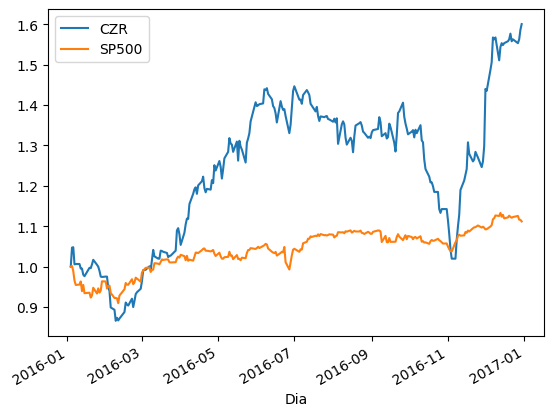

In [215]:
datasets_normalizados[2016][['CZR', 'SP500']].plot()

In [216]:
#Carteiras Anuais
carteiras = {}
for ano in anos:
    base = base_parametros[base_parametros['ANO'] == ano].copy()
    carteira = base.sort_values(['ALPHA', 'BETA', 'CAPM'],ascending=False).head(10).copy()
    carteira = carteira['ATIVO'].values
    carteiras[ano+1] = carteira
    
    

# 3.6 Carteiras

In [217]:
carteiras

{2016: array(['CZR', 'ABMD', 'NFLX', 'AMZN', 'ATVI', 'EPAM', 'NVDA', 'TYL',
        'MKTX', 'GPN'], dtype=object),
 2017: array(['AMD', 'NVDA', 'NEM', 'OKE', 'FCX', 'DXC', 'NDSN', 'PWR', 'AMAT',
        'CZR'], dtype=object),
 2018: array(['SEDG', 'ENPH', 'NRG', 'ANET', 'ALGN', 'NVR', 'TTWO', 'VRTX',
        'WYNN', 'BA'], dtype=object),
 2019: array(['ETSY', 'ENPH', 'DXCM', 'AMD', 'ABMD', 'FTNT', 'PAYC', 'ZBRA',
        'CMG', 'MOH'], dtype=object),
 2020: array(['ENPH', 'SEDG', 'MTCH', 'TGT', 'CMG', 'MKTX', 'PAYC', 'CPRT',
        'TSN', 'DXCM'], dtype=object),
 2021: array(['TSLA', 'MRNA', 'ENPH', 'ETSY', 'SEDG', 'BBWI', 'GNRC', 'NVDA',
        'ALB', 'PYPL'], dtype=object),
 2022: array(['MRNA', 'DVN', 'F', 'MRO', 'EXR', 'SBNY', 'NUE', 'FTNT', 'IRM',
        'PFE'], dtype=object),
 2023: array(['OXY', 'ENPH', 'EQT', 'HES', 'MRO', 'APA', 'MPC', 'VLO', 'SLB',
        'COP'], dtype=object)}

# 3.7 Alocação e Otimização das Carteiras

In [218]:
#Função que devolver valores investidos no intervalo do df
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
    dataset = dataset.copy()

    if seed != 0:
        np.random.seed(seed)

    if len(melhores_pesos) > 0:
        pesos = melhores_pesos
    else:  
        pesos = np.random.random(len(dataset.columns))
        #print(pesos, pesos.sum())
        pesos = pesos / pesos.sum()
        #print(pesos, pesos.sum())

    colunas = dataset.columns
    #print(colunas)
    for i in colunas:
        dataset[i] = (dataset[i] / dataset[i][0])

    for i, acao in enumerate(dataset.columns):
        #print(i, acao)
        dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total
  
    dataset['soma valor'] = dataset.sum(axis = 1)

    datas = dataset.index
    #print(datas)


    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
        dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

    acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos * 100})

    return dataset, datas, acoes_pesos, dataset['soma valor'].values[-1]

In [243]:
# Passando o dataframe das ações escolhidas da carteira conseguimos ver quanto de lucro temos com caso tivessemos
# aplicado no ano em que foi usado para seleção dos ativo da carteira do ano seguinte
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(dfs[2015][carteiras[2016]], dinheiro_total=5000, seed =10)
print(f'valor inicial $ 5000.00\nvalor final $ {round(soma_valor,2)}') #valor em $ ao fim de um ano aplicado

valor inicial $ 5000.00
valor final $ 10387.78


In [238]:
# Pesos em percentual
acoes_pesos

,Ações,Pesos
0,CZR,18.749259
1,ABMD,0.504438
2,NFLX,15.402719
3,AMZN,18.201922
4,ATVI,12.117707
5,EPAM,5.464356
6,NVDA,4.814511
7,TYL,18.486978
8,MKTX,4.110746
9,GPN,2.147364


In [244]:
figura = px.line(x = datas, y = dataset['soma valor'], title = 'Evolução do patrimônio')
figura.show()

In [248]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0

  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns))
    pesos = pesos / pesos.sum()

    for i in dataset.columns:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    retorno_esperado = np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)

    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [274]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(
    dfs[2015][carteiras[2016]], 5000, 0.08, 5000)

In [275]:
melhores_pesos

array([0.20080686, 0.04298664, 0.05052102, 0.30604266, 0.12848501,
       0.11660489, 0.0152105 , 0.02265936, 0.05465162, 0.06203146])

In [276]:
# Passando o dataframe das ações escolhidas da carteira conseguimos ver quanto de lucro temos com caso tivessemos
# aplicado no ano em que foi usado para seleção dos ativo da carteira do ano seguinte
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(dfs[2015][carteiras[2016]], dinheiro_total=5000, melhores_pesos = melhores_pesos)
print(f'valor inicial $ 5000.00\nvalor final $ {round(soma_valor,2)}') #valor em $ ao fim de um ano aplicado

valor inicial $ 5000.00
valor final $ 10644.8


In [277]:
acoes_pesos

,Ações,Pesos
0,CZR,20.080686
1,ABMD,4.298664
2,NFLX,5.052102
3,AMZN,30.604266
4,ATVI,12.848501
5,EPAM,11.660489
6,NVDA,1.521050
7,TYL,2.265936
8,MKTX,5.465162
9,GPN,6.203146


In [278]:
melhor_retorno, melhor_volatilidade

(0.7376426748064657, 0.20693938008362453)

Text(0.5, 1.0, 'Relação Volatilidade Retorno')

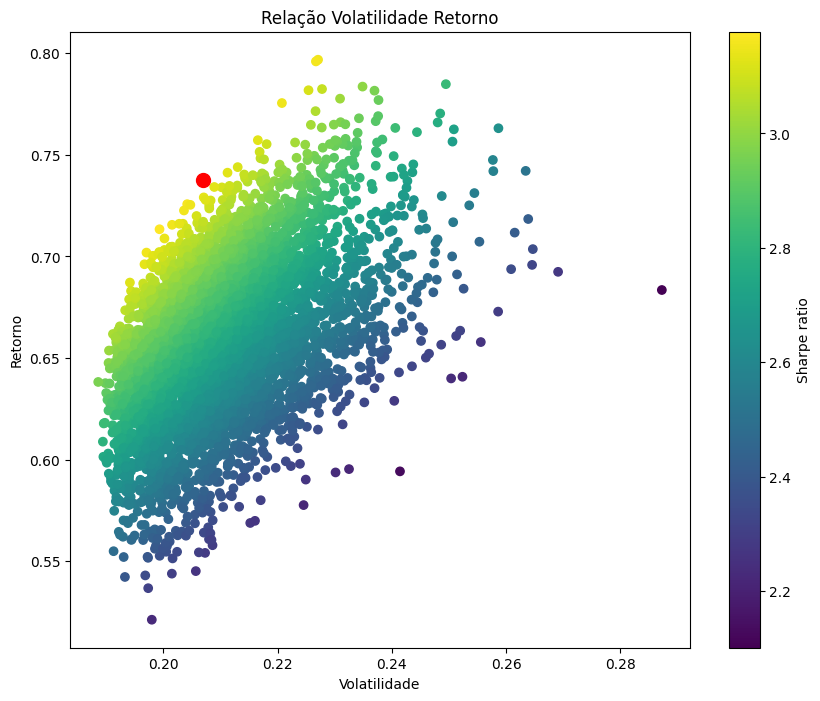

In [279]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);
plt.title('Relação Volatilidade Retorno')

# 3.8 Otimização das Carteira com Markowitz

In [282]:
carteiras_otimizadas = {}
for ano in anos:
    sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(
        dfs[ano][carteiras[ano+1]], 5000, 0.035, 1000)
    dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(dfs[ano][carteiras[ano+1]], dinheiro_total=5000, melhores_pesos = melhores_pesos)
    carteiras_otimizadas[ano+1] = acoes_pesos.copy()
    print('feito', ano)
    

feito 2015
feito 2016
feito 2017
feito 2018
feito 2019
feito 2020
feito 2021
feito 2022


In [305]:
carteiras_otimizadas[2016]

,Ações,Pesos
0,CZR,19.486209
1,ABMD,7.186449
2,NFLX,11.208570
3,AMZN,17.596816
4,ATVI,19.814112
5,EPAM,13.190698
6,NVDA,1.539493
7,TYL,2.925544
8,MKTX,2.628633
9,GPN,4.423477


# 4. Resultados

In [314]:
retorno_carteiras = {}

for ano in range(2015,2022):
    dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(dfs[ano+1][carteiras[ano+1]], dinheiro_total=5000, melhores_pesos = carteiras_otimizadas[ano+1]['Pesos']/100)
    retorno_carteiras[ano+1] = dataset.copy()

In [330]:
retorno_carteiras[2016]

,CZR,ABMD,NFLX,AMZN,ATVI,EPAM,NVDA,TYL,MKTX,GPN,soma valor,taxa retorno
Dia,,,,,,,,,,,,
2016-01-04,974.310472,359.322452,560.428476,879.840799,990.705617,659.534878,76.974664,146.277182,131.431628,221.173832,5000.000000,0.000000
2016-01-05,1020.311910,358.310760,548.706186,875.420811,978.065047,659.359336,78.211206,147.660875,132.405817,224.602052,5023.054000,0.461080
2016-01-06,1021.231960,359.575399,599.774679,873.846158,968.847996,652.424247,74.977180,145.734219,130.806226,225.308906,5052.526970,0.586754
2016-01-07,979.830595,345.327256,583.873093,839.715526,955.154019,634.515931,72.004726,143.439735,128.761621,216.862033,4899.484537,-3.029028
2016-01-08,980.750645,356.540291,567.716698,838.486259,940.406637,618.802261,70.459046,140.672362,127.162030,212.691609,4853.687837,-0.934725
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,1522.647529,473.728967,640.089222,1050.562933,961.210953,561.039205,261.052791,125.714483,179.708216,248.458303,6024.212603,0.281429
2016-12-27,1513.447382,479.461942,654.156047,1065.494235,962.000957,567.096415,278.982635,126.161113,179.792415,249.978034,6076.571175,0.869136
2016-12-28,1522.647529,475.415142,641.618234,1066.502519,959.367543,558.317833,259.792474,125.372940,178.517532,246.231703,6033.783448,-0.704143


In [324]:
retorno_carteiras[2016][['taxa retorno']]

,taxa retorno
Dia,
2016-01-04,0.000000
2016-01-05,0.461080
2016-01-06,0.586754
2016-01-07,-3.029028
2016-01-08,-0.934725
...,...
2016-12-23,0.281429
2016-12-27,0.869136
2016-12-28,-0.704143


In [349]:
datasets_taxa_retorno[2016][['SP500']] * 100

,SP500
Dia,
2016-01-04,0.000000
2016-01-05,0.169136
2016-01-06,-1.261419
2016-01-07,-2.399157
2016-01-08,-1.097658
...,...
2016-12-23,0.146420
2016-12-27,0.248105
2016-12-28,-0.826451


In [350]:
retorno_carteiras_vs_sp500 = {}
for ano in range(2016,2023):
    frame = datasets_taxa_retorno[ano][['SP500']].copy() *100
    frame['carteira'] = retorno_carteiras[ano][['taxa retorno']]
    retorno_carteiras_vs_sp500[ano] = frame.copy()

In [351]:
for ano in range(2016,2023):
    print(f'retorno ano:{ano}\n{retorno_carteiras_vs_sp500[ano].mean() * len(retorno_carteiras_vs_sp500[ano])}\n')

retorno ano:2016
SP500       11.466616
carteira    20.567300
dtype: float64

retorno ano:2017
SP500       17.186622
carteira    42.650218
dtype: float64

retorno ano:2018
SP500      -5.812164
carteira   -3.544426
dtype: float64

retorno ano:2019
SP500       25.992423
carteira    65.321621
dtype: float64

retorno ano:2020
SP500       19.722097
carteira    79.504486
dtype: float64

retorno ano:2021
SP500       26.158557
carteira    56.901960
dtype: float64

retorno ano:2022
SP500      -13.138624
carteira    -9.139290
dtype: float64



In [352]:
for ano in range(2016,2023):
    print(f'Ano: {ano}\n{carteiras_otimizadas[ano]}\n\n')

Ano: 2016
  Ações      Pesos
0   CZR  19.486209
1  ABMD   7.186449
2  NFLX  11.208570
3  AMZN  17.596816
4  ATVI  19.814112
5  EPAM  13.190698
6  NVDA   1.539493
7   TYL   2.925544
8  MKTX   2.628633
9   GPN   4.423477


Ano: 2017
  Ações      Pesos
0   AMD   8.833146
1  NVDA  19.449049
2   NEM  12.790851
3   OKE   3.224959
4   FCX   0.522881
5   DXC   0.159375
6  NDSN  14.798222
7   PWR   7.879855
8  AMAT   8.725285
9   CZR  23.616377


Ano: 2018
  Ações      Pesos
0  SEDG   8.697168
1  ENPH   0.067865
2   NRG  10.594797
3  ANET   3.516269
4  ALGN   5.074646
5   NVR  26.718262
6  TTWO  11.697351
7  VRTX   3.930456
8  WYNN   4.878855
9    BA  24.824331


Ano: 2019
  Ações      Pesos
0  ETSY  23.801056
1  ENPH   9.339274
2  DXCM  21.840183
3   AMD   1.386464
4  ABMD   7.255427
5  FTNT   1.098843
6  PAYC   2.787784
7  ZBRA  12.280638
8   CMG  15.650542
9   MOH   4.559790


Ano: 2020
  Ações      Pesos
0  ENPH  11.743058
1  SEDG   7.408941
2  MTCH   1.384307
3   TGT   7.214372
4   CMG  18